#### Import modules

In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


##### Set some parameters

In [2]:
data = np.load('./segmentation_dir/data.npz')

In [3]:
x_train= data['x_train']
y_train = data['y_train']
x_test = data['x_test']
y_test = data['y_test']


In [4]:
x_train.shape, y_train.shape

((102, 256, 256, 3), (102, 256, 256, 1))

In [5]:
img_width = x_train.shape[1]
img_height =x_train.shape[2]
img_bands = x_train.shape[3]

#### Normalization

In [6]:
inputs = Input((img_width, img_height, img_bands))
s = Lambda(lambda x: x / 255) (inputs)

#### Build U-Net model

In [7]:


c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)


Compile model

In [8]:
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [9]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

results = model.fit(x_train, y_train, 
                    validation_split=0.1, 
                    batch_size=16, epochs=25, 
                    verbose=2,
                    callbacks=[earlystopper, checkpointer])

Train on 91 samples, validate on 11 samples
Epoch 1/25
 - 36s - loss: 0.3283 - acc: 0.8854 - val_loss: 0.1606 - val_acc: 0.9673

Epoch 00001: val_loss improved from inf to 0.16056, saving model to model.h5
Epoch 2/25
 - 34s - loss: 0.2480 - acc: 0.9463 - val_loss: 0.1647 - val_acc: 0.9673

Epoch 00002: val_loss did not improve from 0.16056
Epoch 3/25
 - 34s - loss: 0.2281 - acc: 0.9463 - val_loss: 0.1551 - val_acc: 0.9673

Epoch 00003: val_loss improved from 0.16056 to 0.15509, saving model to model.h5
Epoch 4/25
 - 34s - loss: 0.2219 - acc: 0.9463 - val_loss: 0.1463 - val_acc: 0.9673

Epoch 00004: val_loss improved from 0.15509 to 0.14627, saving model to model.h5
Epoch 5/25
 - 34s - loss: 0.2139 - acc: 0.9463 - val_loss: 0.1417 - val_acc: 0.9673

Epoch 00005: val_loss improved from 0.14627 to 0.14166, saving model to model.h5
Epoch 6/25
 - 34s - loss: 0.2219 - acc: 0.9462 - val_loss: 0.1424 - val_acc: 0.9673

Epoch 00006: val_loss did not improve from 0.14166
Epoch 7/25
 - 34s - loss

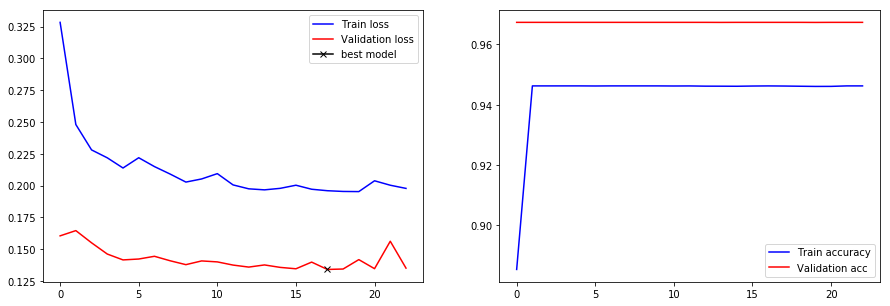

In [100]:


fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].plot(results.history['loss'], color='b', label="Train loss")
ax[0].plot(results.history['val_loss'], color='r',  label="Validation loss")

ax[0].plot(np.argmin(results.history["val_loss"]), 
         np.min(results.history["val_loss"]), 
         marker="x", color="#000000", label="best epoch")

ax[1].plot(results.history['acc'], color='b', label="Train accuracy")
ax[1].plot(results.history['val_acc'], color='r',label="Validation acc")
ax[0].legend()
ax[1].legend()
plt.show()

plt.show()

### Prediction

In [9]:
# Predict on train, val and test
model = load_model('model.h5')
preds_train = model.predict(x_train[:int(x_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(x_train[int(x_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(x_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

26/26 [==============================] - 3s 122ms/step


#### Plot outputs

In [10]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    
    plt.subplot(141), plt.imshow(X[ix,])
    plt.title('Training Data')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(142),plt.imshow(y[ix].squeeze())
    plt.title('Label Data')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(143),plt.imshow(preds[ix].squeeze())
    if has_mask:
        plt.contour(y[ix].squeeze(), colors='r', levels=[0.5])
    plt.title('Predicted output')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(144),plt.imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        plt.contour(y[ix].squeeze(), colors='r', levels=[0.5])
    plt.title('Predicted Binary output')
    plt.xticks([])
    plt.yticks([])
  

Prediction over training data

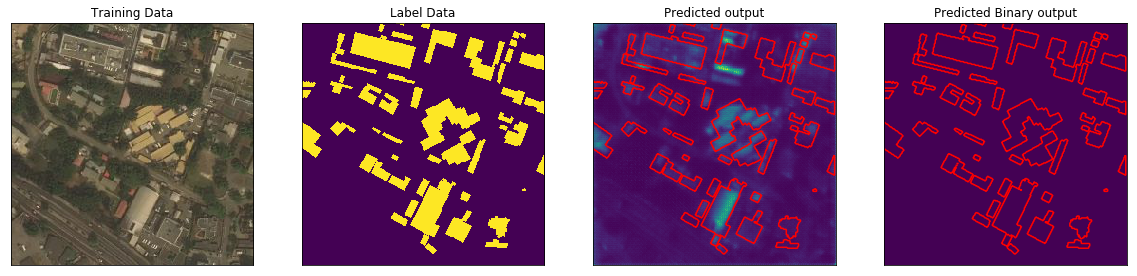

In [11]:
plot_sample(x_train, y_train, preds_train, preds_train_t, ix=19)

Prediction over test data

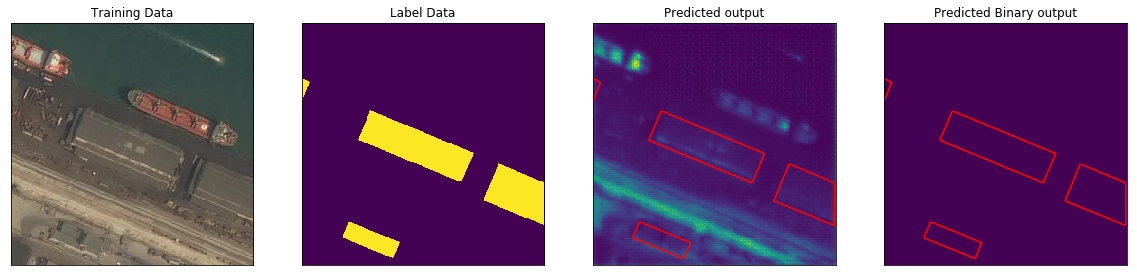

In [12]:
plot_sample(x_test, y_test, preds_test, preds_test_t, ix=19)

#### References


https://www.depends-on-the-definition.com/unet-keras-segmenting-images/ 

https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277# 

https://github.com/divamgupta/image-segmentation-keras/blob/master/Models/Unet.py